# Capstone Project Notebook #4 - Feature Engineering

#### Overview
In the previous 3 notebooks, I cleaned the cleaned and explored the data. I also performed a lengthy web scraping session that was able to extract the YouTube video publish date from the URL so that I can determine how long a song has been released for and evaluate the impact that would have on the amount a views it has.  In the web scraping notebook, I was left with some null values that I'll want to clean up. There are also some columns I want to drop before I start modeling as well as some columns I need to one-hot encode. The purpose of this notebook is finish prepping the data for modeling.

#### Notebook plan
1. Clean `PublishDate` column
2. Engineer 'months_published' column
3. Change `duration_ms` to seconds to improve interpretability
4. One-hot encode `Album_type` and `Key` columns
5. Drop columns like `Url_youtube` that will be unused in modeling

My intended target variable(s) is YouTube Views (and possibly average views per month and Spotify Streams depending on modeling outcomes).

#### Sections
[1. Cleaning Publish Date](#section1)  
[2. Calculate Average Views per Month](#section2)  
[3. Exploration of Number of Months Published](#section3)  
[4. Converting Durtation to Seconds](#section4)  
[5. One-Hot Encoding Album Type & Key](#section5)  
[6. Dropping Unneeded Columns](#section6)  
[7. Export](#section7)

---

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data
df = pd.read_csv('data/data_with_publish_date.csv')

In [3]:
# Examine head
df.head()

,Unnamed: 0,Artist,Track,Album_type,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,...,Url_youtube,Title,Channel,Views,Likes,Comments,Licensed,official_video,Stream,PublishDate
0,0,Gorillaz,Feel Good Inc.,album,0.818,0.705,6.0,-6.679,0.1770,0.008360,...,https://www.youtube.com/watch?v=HyHNuVaZJ-k,Gorillaz - Feel Good Inc. (Official Video),Gorillaz,693555221.0,6220896.0,169907.0,True,True,1.040235e+09,2016-06-28
1,1,Gorillaz,Rhinestone Eyes,album,0.676,0.703,8.0,-5.815,0.0302,0.086900,...,https://www.youtube.com/watch?v=yYDmaexVHic,Gorillaz - Rhinestone Eyes [Storyboard Film] (...,Gorillaz,72011645.0,1079128.0,31003.0,True,True,3.100837e+08,2010-10-04
2,2,Gorillaz,New Gold (feat. Tame Impala and Bootie Brown),single,0.695,0.923,1.0,-3.930,0.0522,0.042500,...,https://www.youtube.com/watch?v=qJa-VFwPpYA,Gorillaz - New Gold ft. Tame Impala & Bootie B...,Gorillaz,8435055.0,282142.0,7399.0,True,True,6.306347e+07,2022-08-31
3,3,Gorillaz,On Melancholy Hill,album,0.689,0.739,2.0,-5.810,0.0260,0.000015,...,https://www.youtube.com/watch?v=04mfKJWDSzI,Gorillaz - On Melancholy Hill (Official Video),Gorillaz,211754952.0,1788577.0,55229.0,True,True,4.346636e+08,2010-06-14
4,4,Gorillaz,Clint Eastwood,album,0.663,0.694,10.0,-8.627,0.1710,0.025300,...,https://www.youtube.com/watch?v=1V_xRb0x9aw,Gorillaz - Clint Eastwood (Official Video),Gorillaz,618480958.0,6197318.0,155930.0,True,True,6.172597e+08,2016-06-28


---

<a id='section1'></a>
#### Cleaning the `PublishDate` Column

In [4]:
# Examine null values
df.isna().sum()

Unnamed: 0            0
Artist                0
Track                 0
Album_type            0
Danceability          0
Energy                0
Key                   0
Loudness              0
Speechiness           0
Acousticness          0
Instrumentalness      0
Liveness              0
Valence               0
Tempo                 0
Duration_ms           0
Url_youtube           0
Title                 0
Channel               0
Views                 0
Likes                 0
Comments              0
Licensed              0
official_video        0
Stream                0
PublishDate         193
dtype: int64

During the web scraping notebook, I was able to extract almost 20,000 publish dates from the corresponding YouTube video. 193 are missing the publish date. I had built the loop that was extracting the dates to attempt the extraction 3 times to avoid connection errors & pass over any rows it was unable to extract the publish date from. These missing values are likely due to a URL that is no longer valid. In the modeling phase, we will examine the perfomance of two different target variables.  
1. Total views (I want to collect the number of months a song has been available to view to enhance this prediction)
2. Streams

Because I need to extract the total number of months a song has been published from that publish date, I will need to drop rows with missing `PublishDate` values.

In [5]:
# Examine data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20099 entries, 0 to 20098
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        20099 non-null  int64  
 1   Artist            20099 non-null  object 
 2   Track             20099 non-null  object 
 3   Album_type        20099 non-null  object 
 4   Danceability      20099 non-null  float64
 5   Energy            20099 non-null  float64
 6   Key               20099 non-null  float64
 7   Loudness          20099 non-null  float64
 8   Speechiness       20099 non-null  float64
 9   Acousticness      20099 non-null  float64
 10  Instrumentalness  20099 non-null  float64
 11  Liveness          20099 non-null  float64
 12  Valence           20099 non-null  float64
 13  Tempo             20099 non-null  float64
 14  Duration_ms       20099 non-null  float64
 15  Url_youtube       20099 non-null  object 
 16  Title             20099 non-null  object

I can also see that the `PublishDate` column datatype is currently an 'object'. I will need to convert that to 'datetime'.

In [6]:
# Examine null values
null_df = df.loc[df['PublishDate'].isna()]

# Examine some null values
null_df.head()

,Unnamed: 0,Artist,Track,Album_type,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,...,Url_youtube,Title,Channel,Views,Likes,Comments,Licensed,official_video,Stream,PublishDate
318,318,JAY-Z,Love All (with JAY-Z),album,0.730,0.576,2.0,-5.442,0.2870,0.3540,...,https://www.youtube.com/watch?v=-xkSZLtgVLQ,"Drake ft. JAY-Z ""Love All"" (Music Video)",RAPTRAX,7101653.0,51843.0,1182.0,False,False,114490460.0,NaN
320,320,21 Savage,Rich Flex,album,0.561,0.520,11.0,-9.342,0.2440,0.0503,...,https://www.youtube.com/watch?v=gOvNACDVXzI,"Drake ft. 21 Savage ""Rich Flex"" (Music Video)",RAPTRAX,3926832.0,54749.0,2569.0,False,False,311694937.0,NaN
327,327,21 Savage,Spin Bout U,album,0.773,0.701,7.0,-6.386,0.0512,0.0100,...,https://www.youtube.com/watch?v=YgP95-kk7sc,"Drake, 21 Savage ""Spin Bout U"" (Music Video)",RAPTRAX,1111996.0,8576.0,154.0,False,False,87618118.0,NaN
343,343,Luis Miguel,Culpable O No - Miénteme Como Siempre,album,0.540,0.367,0.0,-14.238,0.0277,0.0367,...,https://www.youtube.com/watch?v=X-fzpDCxaWc,Luis Miguel - Culpable o No (Miénteme Como Sie...,Manquín Vintage Videos,375491.0,4708.0,234.0,False,False,268107480.0,NaN
368,368,Daddy Yankee,Ella Me Levanto,album,0.760,0.900,5.0,-4.782,0.0668,0.0715,...,https://www.youtube.com/watch?v=9mcyihw330c,Ella Me Levanto - Daddy Yankee (Official Video),DaddyYankee VEVO,864990.0,10360.0,193.0,False,False,201700378.0,NaN


There are some pretty big names like Jay-Z and 21 Savage at the top of this list. If I follow the URLs I can see that the video is no longer available, which would explain why I couldn't extract the publish date. I can also see that most of the videos are not licensed and not from an official channel, which could explain why they were taken down (due property rights).

In [7]:
# Examine count of licensed videos
null_df['Licensed'].value_counts()

False    163
True      30
Name: Licensed, dtype: int64

It looks like I wasn't far off in my assumption, the vast majority of these videos were unlicensed.

In [8]:
# Examine mean Views
print('Mean views w/o publish date:',round(null_df['Views'].mean(), 2))
print('Mean views total data:', round(df['Views'].mean(), 2))

Mean views w/o publish date: 13351368.2
Mean views total data: 94353812.17


There is a pretty big difference the mean number of views in our data with invalid URLs, 13,000,000 to 94,000,000 when compared with the total dataset. 

In [9]:
# Drop rows with missing publish dates
df.dropna(inplace=True)

# Sanity check
df.isna().sum()

Unnamed: 0          0
Artist              0
Track               0
Album_type          0
Danceability        0
Energy              0
Key                 0
Loudness            0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Duration_ms         0
Url_youtube         0
Title               0
Channel             0
Views               0
Likes               0
Comments            0
Licensed            0
official_video      0
Stream              0
PublishDate         0
dtype: int64

Next, I need to convert the `PublishDate` column to datetime.

In [10]:
# Convert PublishDate to datetime
df['PublishDate'] = pd.to_datetime(df['PublishDate'])

# Verify
df.dtypes

Unnamed: 0                   int64
Artist                      object
Track                       object
Album_type                  object
Danceability               float64
Energy                     float64
Key                        float64
Loudness                   float64
Speechiness                float64
Acousticness               float64
Instrumentalness           float64
Liveness                   float64
Valence                    float64
Tempo                      float64
Duration_ms                float64
Url_youtube                 object
Title                       object
Channel                     object
Views                      float64
Likes                      float64
Comments                   float64
Licensed                      bool
official_video                bool
Stream                     float64
PublishDate         datetime64[ns]
dtype: object

---

<a id='section2'></a>
#### Create `avg_views_per_month` Column

Now that I have a clean PublishDate column, I want to engineer a feature that accounts for how long a song has been published. To do this, I want to calulate how long a song has been released and divide the number of views by that value.

In [11]:
# Check min and max Publish Dates
min_date = df['PublishDate'].min()
max_date = df['PublishDate'].max()

print("Minimum Publish Date:", min_date)
print("Maximum Publish Date:", max_date)

Minimum Publish Date: 1964-07-13 00:00:00
Maximum Publish Date: 2023-02-01 00:00:00


I can see that there is a pretty big discrepency in the PublishDate. 1964 seems way too early for a YouTube video to have been published, since YouTube didn't exist in 1964. I'll need to dig into this more deeply. 

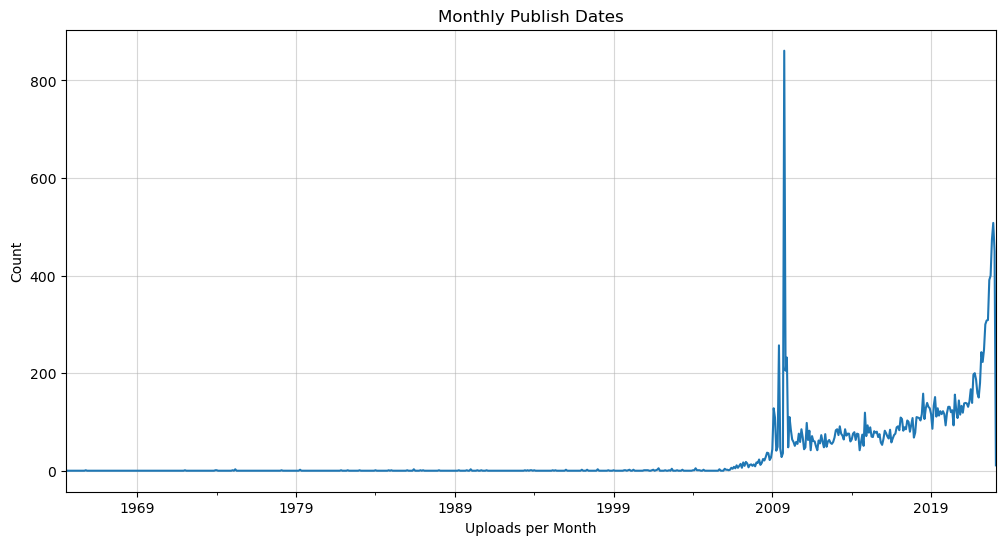

In [12]:
# Plot number of songs published per month
# Group monthly counts
monthly_counts = df.resample('M', on='PublishDate').size()

# Plot
plt.figure(figsize=(12,6))
monthly_counts.plot(kind='line')
plt.title('Monthly Publish Dates')
plt.xlabel('Uploads per Month')
plt.ylabel('Count')
plt.grid(True, alpha=0.5)
plt.show()

This is strange. I have publish dates as far back as 1964 but in very low counts. There is a explosion of publish dates around 2009, which follows an appropriate timeline as YouTube was founded in 2005. 

In [13]:
# Filter Publish Dates before March 2005 (2 weeks after YouTube launch)
mask = df['PublishDate'] <= '2005-03-01'

# Filter
filtered_df = df[mask]

In [14]:
filtered_df.shape

(94, 25)

There are 94 values with publish dates before the launch of YouTube. I'll want to investigate a few of these songs and videos to diagnose what is happening here.

In [15]:
# Randomly sample songs from filtered dataframe
filtered_df.sample(n=10, random_state=42)

,Unnamed: 0,Artist,Track,Album_type,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,...,Url_youtube,Title,Channel,Views,Likes,Comments,Licensed,official_video,Stream,PublishDate
6117,6117,Donna Summer,"I Feel Love - 12"" Version",album,0.692,0.790,5.0,-14.065,0.0416,0.074000,...,https://www.youtube.com/watch?v=6S2n5Tbq_0s,"I Feel Love (12"" Version)",Donna Summer - Topic,2066139.0,32068.0,162.0,True,True,8.446376e+07,1979-04-25
4212,4212,Tom Petty and the Heartbreakers,Christmas All Over Again,compilation,0.521,0.831,9.0,-8.183,0.0326,0.059200,...,https://www.youtube.com/watch?v=gaPj1GoDpQw,"Tom Petty & The Heartbreakers - ""Christmas All...",TURB0lovesTP,990368.0,7019.0,338.0,False,False,4.476788e+07,2000-12-14
7641,7641,Ying Yang Twins,Whistle While You Twurk (ColliPark Mix),album,0.935,0.608,1.0,-7.236,0.0850,0.001550,...,https://www.youtube.com/watch?v=gtfYO6lCPfM,Whistle While You Twurk (ColliPark Mix),Ying Yang Twins - Topic,7586144.0,106964.0,255.0,True,True,8.305528e+06,2000-04-10
8601,8601,Youjeen,Gaja!!!,album,0.250,0.966,11.0,-9.372,0.0549,0.000032,...,https://www.youtube.com/watch?v=0_eyKw1Q-9U,Gaja!!!,youjeen - Topic,191.0,1.0,0.0,True,True,8.729959e+07,2002-09-26
74,74,Radiohead,Exit Music (For A Film),album,0.293,0.276,4.0,-11.357,0.0349,0.224000,...,https://www.youtube.com/watch?v=Bf01riuiJWA,Exit Music (For A Film),Radiohead - Topic,10644157.0,171322.0,1669.0,True,True,1.468579e+08,1997-05-28
4949,4949,Eazy-E,Gimmie That Nutt,album,0.947,0.854,7.0,-5.028,0.2160,0.011700,...,https://www.youtube.com/watch?v=caSi8ccqWmg,Gimmie That Nutt,Eazy-E - Topic,2922942.0,50805.0,216.0,True,True,2.133098e+07,1993-11-05
6115,6115,Donna Summer,"Hot Stuff - 12"" Version",album,0.796,0.892,0.0,-8.310,0.0333,0.004750,...,https://www.youtube.com/watch?v=tJxOXzE5A8w,"Hot Stuff (12"" Version)",Donna Summer - Topic,9394797.0,93272.0,370.0,True,True,1.246652e+08,1979-04-25
8595,8595,Youjeen,HAPPY HAPPY DOLL,album,0.406,0.883,2.0,-3.474,0.0406,0.000004,...,https://www.youtube.com/watch?v=_lyF7Jhzf9Q,Youjeen - Happy Happy Doll,cherryfilter,891.0,20.0,4.0,False,False,8.729995e+07,2001-07-25
3084,3084,Grupo Niche,Se Pareció Tanto a Ti,compilation,0.559,0.778,0.0,-10.517,0.0392,0.512000,...,https://www.youtube.com/watch?v=_BnwvqPUpik,Se Pareció Tanto a Ti,Grupo Niche - Topic,147164586.0,342913.0,1862.0,True,True,1.999138e+07,1990-06-08
6575,6575,Böhse Onkelz,Leere Worte,album,0.558,0.869,10.0,-5.068,0.0508,0.006700,...,https://www.youtube.com/watch?v=TCziWjuchj4,Leere Worte,Böhse Onkelz - Topic,1735165.0,10792.0,20.0,True,True,1.043818e+07,1998-09-07


I've discovered the problem, in the web scraping notebook, the intention was to extract the date field that followed the string "datePublished" which contains the only date field IF the date was not contained somewhere else in the description. In a few rare cases, the release date was included in the description of some pages (see "Gimme That Nutt by Easy-E https://www.youtube.com/watch?v=caSi8ccqWmg). However, in most cases the `PublishDate` is the upload date of this song. Given the time constraints of this project and the lengthy period (12+ hours) needed to web scrape for the entire dateset before validating the dates, I will need to proceed with the values that have been filled. I've randomly tested some URLs with upload dates after 2005 and they were accurate to the upload date. As a workaround to this problem, I will drop the small number of songs that have a `PublishDate` before March 1, 2005 so that I can proceed with the engineering. 

Should time allow, I will attempt the web scrape again in the future and update the data.

In [16]:
# Drop rows with publish dates before March 1, 2005
df.drop(df[mask].index, inplace=True)

# Sanity Check
df.shape

(19812, 25)

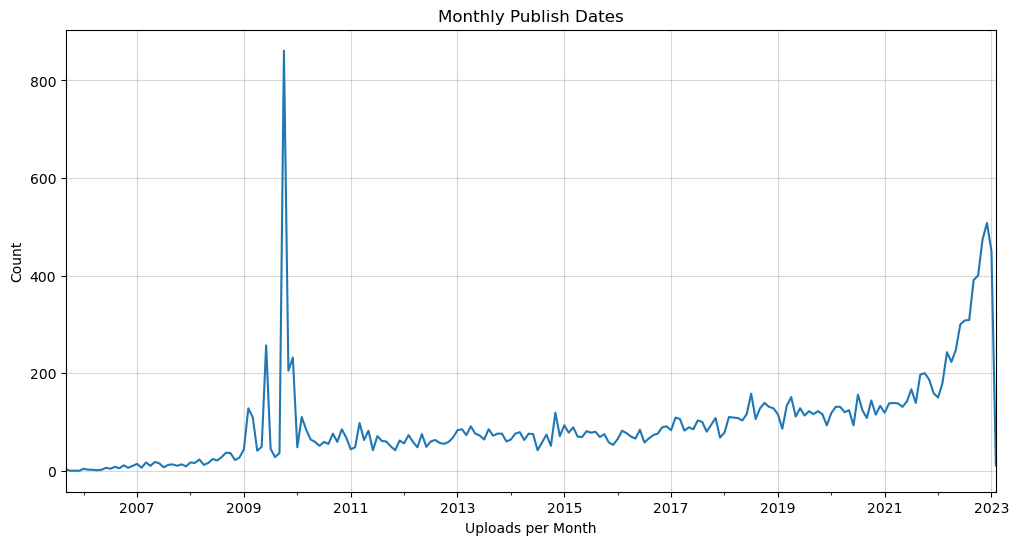

In [17]:
# Plot number of songs published per month
# Group monthly counts
monthly_counts = df.resample('M', on='PublishDate').size()

# Plot
plt.figure(figsize=(12,6))
monthly_counts.plot(kind='line')
plt.title('Monthly Publish Dates')
plt.xlabel('Uploads per Month')
plt.ylabel('Count')
plt.grid(True, alpha=0.5)
plt.show()

Now that I've dropped the incorrect publish dates I can see that there was what looks like an explosion of uploads towards the end of 2009, followed by a steady upload rate from 2010 to around 2022 when there was a surge of video uploads.  

Now that I have the `PublishDate` column cleaned up, I'll want to calculate how many months a song has been uploaded for. I'll do this by subtracting the publish date from the date the data was collected. To do this, I need to make an assumption about when the data was collected. This dataset was released on [March 20, 2023](https://www.kaggle.com/datasets/salvatorerastelli/spotify-and-youtube). I have to make an assumption about when the data was collected. For the sake of simplicity, I'm going to assume that this data was collected on March 1, 2023, give or take a few days, which won't make the biggest difference in the calculation we're making. Perhaps it was performed in January 2023, because that is when the dates stop, but lets give a couple of months as a buffer.

In [18]:
# Calculate the months a song has been published
# Set data collection date
collection_date = pd.Timestamp('2023-03-01')

# Calculate difference in days
days_difference = (collection_date - df['PublishDate']).dt.days

# Round to nearest value in months
months_published = np.ceil(days_difference / 30).astype(int) # np.ceil to round up to nearest month number (minimum 1)

In [19]:
# Verify
months_published.describe()

count    19812.000000
mean        72.738038
std         57.570566
min          1.000000
25%         19.000000
50%         59.000000
75%        122.000000
max        213.000000
Name: PublishDate, dtype: float64

In [20]:
# Add to dataframe
df['months_published'] = months_published

In [21]:
# Verify
df.head()

,Unnamed: 0,Artist,Track,Album_type,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,...,Title,Channel,Views,Likes,Comments,Licensed,official_video,Stream,PublishDate,months_published
0,0,Gorillaz,Feel Good Inc.,album,0.818,0.705,6.0,-6.679,0.1770,0.008360,...,Gorillaz - Feel Good Inc. (Official Video),Gorillaz,693555221.0,6220896.0,169907.0,True,True,1.040235e+09,2016-06-28,82
1,1,Gorillaz,Rhinestone Eyes,album,0.676,0.703,8.0,-5.815,0.0302,0.086900,...,Gorillaz - Rhinestone Eyes [Storyboard Film] (...,Gorillaz,72011645.0,1079128.0,31003.0,True,True,3.100837e+08,2010-10-04,152
2,2,Gorillaz,New Gold (feat. Tame Impala and Bootie Brown),single,0.695,0.923,1.0,-3.930,0.0522,0.042500,...,Gorillaz - New Gold ft. Tame Impala & Bootie B...,Gorillaz,8435055.0,282142.0,7399.0,True,True,6.306347e+07,2022-08-31,7
3,3,Gorillaz,On Melancholy Hill,album,0.689,0.739,2.0,-5.810,0.0260,0.000015,...,Gorillaz - On Melancholy Hill (Official Video),Gorillaz,211754952.0,1788577.0,55229.0,True,True,4.346636e+08,2010-06-14,155
4,4,Gorillaz,Clint Eastwood,album,0.663,0.694,10.0,-8.627,0.1710,0.025300,...,Gorillaz - Clint Eastwood (Official Video),Gorillaz,618480958.0,6197318.0,155930.0,True,True,6.172597e+08,2016-06-28,82


Now to calculate the number of average monthly views.

In [22]:
# Create avg_monthly_views column
df['avg_views_per_month'] = (df['Views'] / df['months_published'])

# Verify
df.head()

,Unnamed: 0,Artist,Track,Album_type,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,...,Channel,Views,Likes,Comments,Licensed,official_video,Stream,PublishDate,months_published,avg_views_per_month
0,0,Gorillaz,Feel Good Inc.,album,0.818,0.705,6.0,-6.679,0.1770,0.008360,...,Gorillaz,693555221.0,6220896.0,169907.0,True,True,1.040235e+09,2016-06-28,82,8.457990e+06
1,1,Gorillaz,Rhinestone Eyes,album,0.676,0.703,8.0,-5.815,0.0302,0.086900,...,Gorillaz,72011645.0,1079128.0,31003.0,True,True,3.100837e+08,2010-10-04,152,4.737608e+05
2,2,Gorillaz,New Gold (feat. Tame Impala and Bootie Brown),single,0.695,0.923,1.0,-3.930,0.0522,0.042500,...,Gorillaz,8435055.0,282142.0,7399.0,True,True,6.306347e+07,2022-08-31,7,1.205008e+06
3,3,Gorillaz,On Melancholy Hill,album,0.689,0.739,2.0,-5.810,0.0260,0.000015,...,Gorillaz,211754952.0,1788577.0,55229.0,True,True,4.346636e+08,2010-06-14,155,1.366161e+06
4,4,Gorillaz,Clint Eastwood,album,0.663,0.694,10.0,-8.627,0.1710,0.025300,...,Gorillaz,618480958.0,6197318.0,155930.0,True,True,6.172597e+08,2016-06-28,82,7.542451e+06


In [23]:
# Check distribution
df['avg_views_per_month'].describe()

count    1.981200e+04
mean     1.979381e+06
std      5.306613e+06
min      0.000000e+00
25%      5.325805e+04
50%      3.286715e+05
75%      1.512416e+06
max      1.260756e+08
Name: avg_views_per_month, dtype: float64

It looks like there are some values of zero for views, which might be causing some minimum values of zero views per month.

In [24]:
# Check view values
df['Views'].describe()

count    1.981200e+04
mean     9.557127e+07
std      2.773189e+08
min      0.000000e+00
25%      1.959970e+06
50%      1.511890e+07
75%      7.168899e+07
max      8.079649e+09
Name: Views, dtype: float64

---

<a id='section3'></a>
#### Explore Number of Months Published

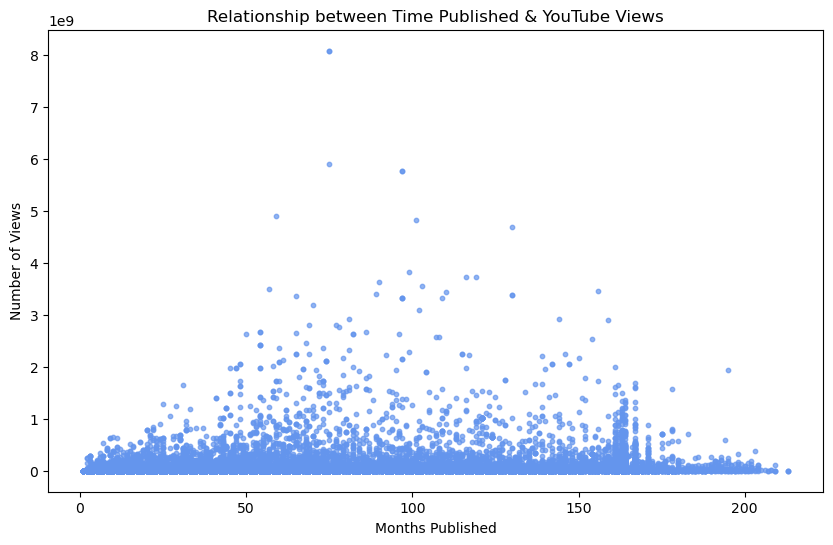

In [25]:
# Plot relationship between months a song has been published and views
plt.figure(figsize=(10,6))

# Plot
plt.scatter(df['months_published'], df['Views'], color='cornflowerblue', alpha=0.7, s=10)

# Label
plt.title('Relationship between Time Published & YouTube Views')
plt.xlabel('Months Published')
plt.ylabel('Number of Views')

plt.show()

The above plot shows the relationship between how long a song has been out and how many views it has. My expectation was to see a strong relationship between the time it was published and the amount of views it had. This is a good case as to why one should test their assumptions. This plot may not be giving the full picture. I still feel it's valuable to discount the number of views a song has by how long it's been posted in some circumstances. Let's check the correlation of features across total views and average monthly views.

Text(0.5, 1.0, 'Correlation Heatmap (Views & Avg. Views/Month)')

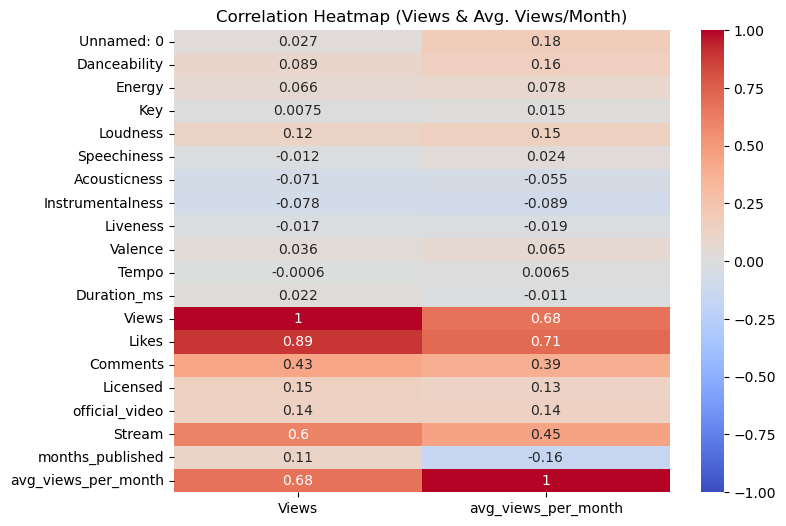

In [26]:
# Plot correlation between features & target variables
corr_matrix = df.corr()

# Filter for target variables
target_corr = corr_matrix[['Views', 'avg_views_per_month']]

plt.figure(figsize=(8,6))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Views & Avg. Views/Month)')

There are some minor changes in the correlation. Nothing groundbreaking. The most noticeable change is in "Danceability" in which we see the correlation shift from 0.089 to 0.16.

---

<a id='section4'></a>
#### Convert `Duration_ms` to Seconds

Most people don't think of time in terms of milliseconds. Songs are displayed in total minutes, or seconds. To help with the interpretability of this data, I think it would be helpful to adjust the milliseconds to seconds. 

In [27]:
df['Duration_ms']

0        222640.0
1        200173.0
2        215150.0
3        233867.0
4        340920.0
           ...   
20094     94667.0
20095    150857.0
20096    136842.0
20097    108387.0
20098    181500.0
Name: Duration_ms, Length: 19812, dtype: float64

In [28]:
# Convert duration_ms to seconds
df['Duration_ms'] = round(df['Duration_ms']/1000)

In [29]:
# Rename the column
df.rename(columns={'Duration_ms': 'duration_sec'}, inplace=True)

In [30]:
# Verify
df['duration_sec']

0        223.0
1        200.0
2        215.0
3        234.0
4        341.0
         ...  
20094     95.0
20095    151.0
20096    137.0
20097    108.0
20098    182.0
Name: duration_sec, Length: 19812, dtype: float64

The change has been made, but the data is still a float. Lets clean it up and make it an integer.

In [31]:
# Change datatype to integer
df['duration_sec'] = df['duration_sec'].astype(int)

---

<a id='section5'></a>
#### One-hot Encode `Album_type` and `Key` columns

In the EDA notebook, I noticed that the `Key` column is numbered according to [pitch class notation](https://en.wikipedia.org/wiki/Pitch_class). This numbering makes sense in the context of musical theory, but not in the context of the problem we are trying to solve. As such, I would like to one-encode the `key` column alongside the `album_type` column. 

In [32]:
# One-hot encode Album_type
df = pd.get_dummies(df, columns=['Album_type'], prefix='')

In [33]:
# Verify
df.columns

Index(['Unnamed: 0', 'Artist', 'Track', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'duration_sec', 'Url_youtube', 'Title',
       'Channel', 'Views', 'Likes', 'Comments', 'Licensed', 'official_video',
       'Stream', 'PublishDate', 'months_published', 'avg_views_per_month',
       '_album', '_compilation', '_single'],
      dtype='object')

In [34]:
# Drop the reference category '_album'
df.drop('_album', axis=1, inplace=True)

In the EDA notebook, I created a dictionary for the keys to plot out their distribution. I'll do the same here and drop the key of C as the reference category.

In [35]:
# Convert key datatype from float to int
df['Key'] = df['Key'].astype(int)

# Instantiate key dictionary
key_dict = {0:'C', 
            1:'C#/Db', 
            2:'D',
            3:'D#/Eb',
            4:'E',
            5:'F',
            6:'F#/Gb',
            7:'G',
            8:'G#/Ab',
            9:'A',
            10:'A#/Bb',
            11:'B'
           }

In [36]:
# Replace integers with key values
df['Key'] = df['Key'].replace(key_dict)

In [37]:
# One-hot encode keys
df = pd.get_dummies(df, columns=['Key'], prefix='')

In [38]:
# Verify
df.columns

Index(['Unnamed: 0', 'Artist', 'Track', 'Danceability', 'Energy', 'Loudness',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'duration_sec', 'Url_youtube', 'Title', 'Channel',
       'Views', 'Likes', 'Comments', 'Licensed', 'official_video', 'Stream',
       'PublishDate', 'months_published', 'avg_views_per_month',
       '_compilation', '_single', '_A', '_A#/Bb', '_B', '_C', '_C#/Db', '_D',
       '_D#/Eb', '_E', '_F', '_F#/Gb', '_G', '_G#/Ab'],
      dtype='object')

In [39]:
# Drop the reference category '_C'
df.drop('_C', axis=1, inplace=True)

In [40]:
# Examine new shape of the dataframe
df.shape

(19812, 38)

---

<a id='section6'></a>
#### Drop Unneeded Columns

In [41]:
# Print columns in dataframe
for col in df.columns:
    print(col)

Unnamed: 0
Artist
Track
Danceability
Energy
Loudness
Speechiness
Acousticness
Instrumentalness
Liveness
Valence
Tempo
duration_sec
Url_youtube
Title
Channel
Views
Likes
Comments
Licensed
official_video
Stream
PublishDate
months_published
avg_views_per_month
_compilation
_single
_A
_A#/Bb
_B
_C#/Db
_D
_D#/Eb
_E
_F
_F#/Gb
_G
_G#/Ab


For the actual modelling piece of this project, I want to keep only the data that I'll need for the actual modeling. As such I'll be dropping the following columns:
- Unnamed: 0 - Index that carried over into a column
- Artist - Not needed, perhaps I may come back and OHE if time permits
- Track - The name of the track is irrelevant in the modeling portion
- Url_youtube - no longer needed
- Title - A case could be made around how certain words might improve click rate and thus views, but that is not the focus of this project
- Channel - A similar case could be made as "Title", but again, this is not the focus of the project
- Likes - Not needed, not independent of the target variable "Views"
- Comments - Same problem as "likes"
- Licensed - Not needed (This along with "official_video" touches more on the marketing components of releasing a song, which is not the focus of this project)
- official_video - Not needed 
- PublishDate - Only needed for feature engineering (Perhaps there is seasonality associated with when a song is uploaded, will explore if time permits)

In [42]:
# Drop the specified columns
df.drop(['Unnamed: 0',
         'Artist',
         'Track',
         'Url_youtube',
         'Title',
         'Channel',
         'Likes',
         'Comments',
         'Licensed',
         'official_video',
         'PublishDate',
        ], axis=1, inplace=True)

In [43]:
# Verify
for col in df.columns:
    print(col)

Danceability
Energy
Loudness
Speechiness
Acousticness
Instrumentalness
Liveness
Valence
Tempo
duration_sec
Views
Stream
months_published
avg_views_per_month
_compilation
_single
_A
_A#/Bb
_B
_C#/Db
_D
_D#/Eb
_E
_F
_F#/Gb
_G
_G#/Ab


In [44]:
# Reset index (I didn't do this earlier)
df.reset_index(drop=True)

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,duration_sec,...,_A#/Bb,_B,_C#/Db,_D,_D#/Eb,_E,_F,_F#/Gb,_G,_G#/Ab
0,0.818,0.705,-6.679,0.1770,0.008360,0.002330,0.6130,0.7720,138.559,223,...,0,0,0,0,0,0,0,1,0,0
1,0.676,0.703,-5.815,0.0302,0.086900,0.000687,0.0463,0.8520,92.761,200,...,0,0,0,0,0,0,0,0,0,1
2,0.695,0.923,-3.930,0.0522,0.042500,0.046900,0.1160,0.5510,108.014,215,...,0,0,1,0,0,0,0,0,0,0
3,0.689,0.739,-5.810,0.0260,0.000015,0.509000,0.0640,0.5780,120.423,234,...,0,0,0,1,0,0,0,0,0,0
4,0.663,0.694,-8.627,0.1710,0.025300,0.000000,0.0698,0.5250,167.953,341,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19807,0.582,0.926,-6.344,0.0328,0.448000,0.000000,0.0839,0.6580,90.002,95,...,0,0,0,0,0,0,1,0,0,0
19808,0.531,0.936,-1.786,0.1370,0.028000,0.000000,0.0923,0.6570,174.869,151,...,0,0,0,0,0,1,0,0,0,0
19809,0.443,0.830,-4.679,0.0647,0.024300,0.000000,0.1540,0.4190,168.388,137,...,0,0,0,0,0,1,0,0,0,0
19810,0.417,0.767,-4.004,0.4190,0.356000,0.018400,0.1080,0.5390,155.378,108,...,0,0,0,0,0,0,0,0,0,0


This looks much cleaner. I now have isolated the predictor variables, like danceability, duration, months published, and key, and have 2 target variables to analyze in the modeling stage: `Views` and `Streams`.

---

<a id='section7'></a>
#### Export

In [45]:
# Export data
df.to_csv('data/modelling_data.csv', index=False)

---